In [4]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from client.image_data_generator import ImageDataGenerator

In [5]:
DATASET_PATH = "./images-data1/"
TEST_DATASET_PATH = "./images-data1-test/"
MASK_PATH = "./images-data1-mask/mask-2.mat"

EMBEDDING_FEATURE_DIM = 128

EPOCHS = 10
BATCH_SIZE = 4

In [6]:
train_data = ImageDataGenerator(dataset_path=DATASET_PATH, mask_path=MASK_PATH)
test_data = ImageDataGenerator(dataset_path=TEST_DATASET_PATH, mask_path=MASK_PATH)

In [7]:
train_ds = (
    tf.data.Dataset.from_generator(
        train_data,
        output_types=(tf.float32, tf.float32),
        output_shapes=(
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        ),
    )
    .shuffle(100)
    .batch(BATCH_SIZE)
)


test_ds = tf.data.Dataset.from_generator(
    test_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=(
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
    ),
).batch(1)

In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(EMBEDDING_FEATURE_DIM)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(2, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(EMBEDDING_FEATURE_DIM),
    ]
)

model.compile(loss="mse", optimizer="adam", metrics="mse")

In [9]:
model.fit(train_ds, epochs=EPOCHS)

Epoch 1/10


2023-12-04 10:50:01.833471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before m

      4/Unknown - 6s 95ms/step - loss: 0.0410 - mse: 0.0410

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


      6/Unknown - 6s 96ms/step - loss: 0.0396 - mse: 0.0396

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 7s 26ms/step - loss: 0.0309 - mse: 0.0309
Epoch 2/10


2023-12-04 10:50:08.406370: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8711376753771901342
2023-12-04 10:50:08.406388: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12100396146644632542
2023-12-04 10:50:08.406391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11393766789312742502
2023-12-04 10:50:08.406395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17467549694656215792
2023-12-04 10:50:08.406403: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16919704682934140706
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous

 2/32 [>.............................] - ETA: 3s - loss: 0.0197 - mse: 0.0197  

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


 4/32 [==>...........................] - ETA: 2s - loss: 0.0198 - mse: 0.0198

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


 6/32 [====>.........................] - ETA: 2s - loss: 0.0193 - mse: 0.0193

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 25ms/step - loss: 0.0160 - mse: 0.0160
Epoch 3/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of da

 2/32 [>.............................] - ETA: 3s - loss: 0.0109 - mse: 0.0109  

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


 4/32 [==>...........................] - ETA: 2s - loss: 0.0104 - mse: 0.0104

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


 6/32 [====>.........................] - ETA: 2s - loss: 0.0105 - mse: 0.0105

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 25ms/step - loss: 0.0096 - mse: 0.0096
Epoch 4/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of da

 2/32 [>.............................] - ETA: 2s - loss: 0.0108 - mse: 0.0108  

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


 4/32 [==>...........................] - ETA: 2s - loss: 0.0099 - mse: 0.0099

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


 6/32 [====>.........................] - ETA: 2s - loss: 0.0087 - mse: 0.0087

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 25ms/step - loss: 0.0072 - mse: 0.0072
Epoch 5/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of da

 2/32 [>.............................] - ETA: 2s - loss: 0.0070 - mse: 0.0070  

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


 4/32 [==>...........................] - ETA: 2s - loss: 0.0066 - mse: 0.0066

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


 6/32 [====>.........................] - ETA: 2s - loss: 0.0059 - mse: 0.0059

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 25ms/step - loss: 0.0059 - mse: 0.0059
Epoch 6/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of da

 1/32 [..............................] - ETA: 1:13 - loss: 0.0042 - mse: 0.0042

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


 4/32 [==>...........................] - ETA: 2s - loss: 0.0048 - mse: 0.0048

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


 6/32 [====>.........................] - ETA: 2s - loss: 0.0049 - mse: 0.0049

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 24ms/step - loss: 0.0051 - mse: 0.0051
Epoch 7/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of da

 3/32 [=>............................] - ETA: 2s - loss: 0.0054 - mse: 0.0054 

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 5/32 [===>..........................] - ETA: 2s - loss: 0.0053 - mse: 0.0053

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 7/32 [=====>........................] - ETA: 2s - loss: 0.0049 - mse: 0.0049

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 26ms/step - loss: 0.0045 - mse: 0.0045
Epoch 8/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of da

 3/32 [=>............................] - ETA: 2s - loss: 0.0038 - mse: 0.0038 

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 5/32 [===>..........................] - ETA: 2s - loss: 0.0040 - mse: 0.0040

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 7/32 [=====>........................] - ETA: 2s - loss: 0.0042 - mse: 0.0042

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 25ms/step - loss: 0.0041 - mse: 0.0041
Epoch 9/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of da

 3/32 [=>............................] - ETA: 2s - loss: 0.0038 - mse: 0.0038 

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 5/32 [===>..........................] - ETA: 2s - loss: 0.0043 - mse: 0.0043

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


12/32 [==========>...................] - ETA: 1s - loss: 0.0043 - mse: 0.0043

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 24ms/step - loss: 0.0039 - mse: 0.0039
Epoch 10/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of da

 2/32 [>.............................] - ETA: 2s - loss: 0.0053 - mse: 0.0053  

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


 4/32 [==>...........................] - ETA: 2s - loss: 0.0042 - mse: 0.0042

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


 6/32 [====>.........................] - ETA: 2s - loss: 0.0041 - mse: 0.0041

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - mse: 0.0038

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


32/32 [==============================] - 3s 25ms/step - loss: 0.0038 - mse: 0.0038


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 1s 574ms/step


Corrupt JPEG data: premature end of data segment


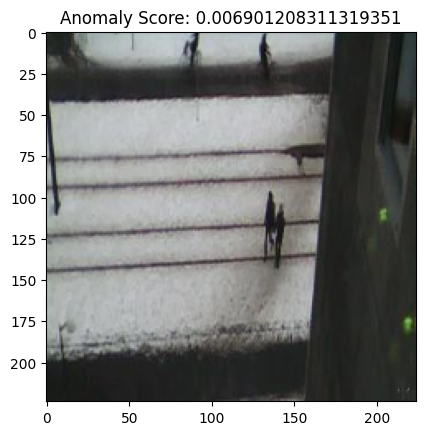

1/1 [==============================] - 0s 17ms/step


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


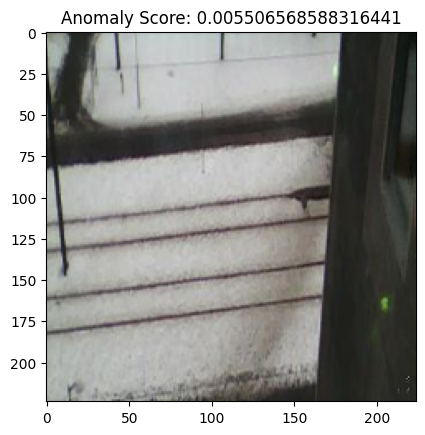

1/1 [==============================] - 0s 16ms/step


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


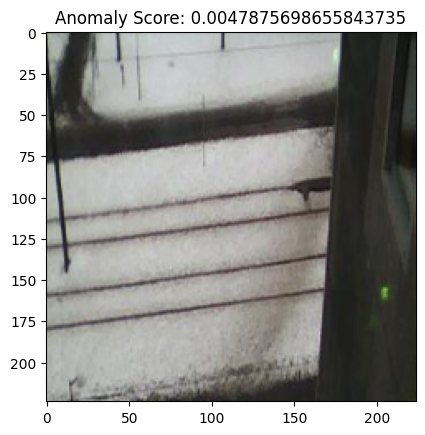

1/1 [==============================] - 0s 13ms/step


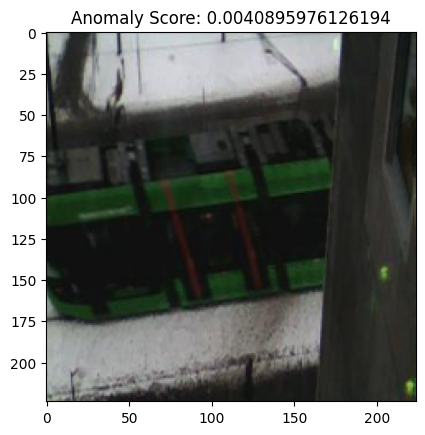

In [10]:
for ix, (x, y) in enumerate(test_ds):
    pred = model.predict(x)

    score = tf.reduce_mean(tf.math.square(x - pred))

    plt.figure()
    plt.imshow(test_data.get_image(ix, apply_mask=False))
    plt.title(f"Anomaly Score: {score}")
    plt.show()